<a href="https://colab.research.google.com/github/mrpintime/Santander-Customer-Transaction/blob/main/SantanderCustomerTransaction(Kaggle_competition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Specific Transactions
Created by Moein aka Mrpintime

# **DataSet Description**:
`name`: SantanderCustomerSatisfaction
`version`: 3
`Author`: Banco Santander
`description`:
At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

**Dataset taken from Kaggle**: https://www.kaggle.com/c/santander-customer-transaction-prediction/data


---


# Problem


In this challenge, we want to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted.
**Note**: The data provided for this competition has the same structure as the real data we have available to solve this problem.

# Import files from Kaggle

In [ ]:
# !pip install opendatasets
# import opendatasets as op
# op.download("https://www.kaggle.com/competitions/santander-customer-transaction-prediction/data")

Install cuML and lightgbm for faster computing

In [1]:
# this cell is for install cuML on Colab
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
# install LightGBM
# !pip install lightgbm

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 6.69 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.4 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.

# Pre-processing (Cleansing)

Import necessary libraries

In [2]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt

In [ ]:
# save files to google drive
# ! cp -r "/content/santander-customer-transaction-prediction/" "/content/drive/MyDrive/"

Read train and test set

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/santander-customer-transaction-prediction/train.csv")
# df_test = pd.read_csv("/content/drive/MyDrive/santander-customer-transaction-prediction/test.csv")

**Note**: We have a very large dataset

In [ ]:
df_test.shape, df_train.shape

((200000, 201), (200000, 202))

Check the null values, feature variables, target variable and clean them

In [ ]:
df_train.isnull().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

So we do not have missing values in train and test set

In [ ]:
df_test.isnull().sum().sum(), df_train.isnull().sum().sum()

(0, 0)

so test set does not have target features and all other features are same with test set

In [ ]:
set(df_train.columns) - set(df_test.columns)

{'target'}

In [ ]:
df_train.dtypes

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 202, dtype: object

In [ ]:
df_train.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

So `ID_code` values are unique and we can't get valuable info from it, We do not need `ID_code` column anymore.

In [ ]:
df_train.ID_code.is_unique

True

In [4]:
df_train = df_train.drop(columns='ID_code')

We have very imbalabce dataset.

In [ ]:
df_train.target.value_counts(normalize=1)

0    0.89951
1    0.10049
Name: target, dtype: float64

In [ ]:
df_train.head()

target    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266   
1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338   
2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155   
3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250   
4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514   

    var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0 -4.9200  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   7.8784   
1  3.1468  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   8.1267   
2 -4.9193  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417  -6.5213   
3 -5.8609  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706  -2.9275   
4  6.2654  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   3.9267   

   var_197  var_198  var_199  
0   8.5635  12.7803  -1.0914  
1   8.7889  18.3560   1.9518  
2   8.2675  14.7222   0.3965  
3  10.2922  17.9697  -8.9996  
4   9.5031  17.9974  -8.8104  

[5 rows x 201 columns]

# Exploratory Data Analysis

Study columns features and correlation in train and test set.
**Note**: The dataset has had PCA or some feature transforming applied to the features to provide customer anonymity. 200 Columns (var_0-var_199) are the resulting principal components.

Cell for free the memory when working with big dataset.
References : [Stackoverflow](https://stackoverflow.com/questions/1316767/how-can-i-explicitly-free-memory-in-python)

In [ ]:
# According to Python Official Documentation, you can explicitly invoke the Garbage Collector to release unreferenced memory with gc.collect(). Example:

# import gc

# gc.collect()

# You should do that after marking what you want to discard using del:

# del my_array
# del my_object
# gc.collect()



Descriptive statistic for train and test set

In [ ]:
df_train.describe()

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [ ]:
df_test.describe()

var_0          var_1          var_2          var_3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       10.658737      -1.624244      10.707452       6.788214   
std         3.036716       4.040509       2.633888       2.052724   
min         0.188700     -15.043400       2.355200      -0.022400   
25%         8.442975      -4.700125       8.735600       5.230500   
50%        10.513800      -1.590500      10.560700       6.822350   
75%        12.739600       1.343400      12.495025       8.327600   
max        22.323400       9.385100      18.714100      13.142000   

               var_4          var_5          var_6          var_7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       11.076399      -5.050558       5.415164      16.529143   
std         1.616456       7.869293       0.864686       3.424482   
min         5.484400     -27.767000       2.216400       5.713700   
25%         9.891075     -11.201400       4.772600      13.933900   
50%        11.099750      -4.834100       5.391600      16.422700   
75%        12.253400       0.942575       6.005800      19.094550   
max        16.037100      17.253700       8.302500      28.292800   

               var_8          var_9  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean        0.277135       7.569407  ...       3.189766       7.458269   
std         3.333375       1.231865  ...       4.551239       3.025189   
min        -9.956000       4.243300  ...     -14.093300      -2.407000   
25%        -2.303900       6.623800  ...      -0.095000       5.166500   
50%         0.372000       7.632000  ...       3.162400       7.379000   
75%         2.930025       8.584825  ...       6.336475       9.531100   
max         9.665500      11.003600  ...      20.359000      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.925944       3.322016      17.996967      -0.133657   
std         1.479966       3.995599       3.140652       1.429678   
min        -3.340900     -11.413100       9.382800      -4.911900   
25%         0.882975       0.587600      15.634775      -1.160700   
50%         1.892600       3.428500      17.977600      -0.162000   
75%         2.956000       6.174200      20.391725       0.837900   
max         8.005000      17.632600      27.947800       4.545400   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.290899       8.912428      15.869184      -3.246342  
std         5.446346       0.920904       3.008717      10.398589  
min       -13.944200       6.169600       6.584000     -39.457800  
25%        -1.948600       8.260075      13.847275     -11.124000  
50%         2.403600       8.892800      15.943400      -2.725950  
75%         6.519800       9.595900      18.045200       4.935400  
max        15.920700      12.275800      26.538400      27.907400  

[8 rows x 200 columns]

Pearson correlation

In [ ]:
df_train.corrwith(df_train['target']).abs().sort_values(ascending=False)

target     1.000000
var_81     0.080917
var_139    0.074080
var_12     0.069489
var_6      0.066731
             ...   
var_38     0.000970
var_17     0.000864
var_30     0.000638
var_27     0.000582
var_185    0.000053
Length: 201, dtype: float64

Pairwise plot.
In plot we `can't see obvious correlation between features` and as we can see the distribution of each features are approximately same.

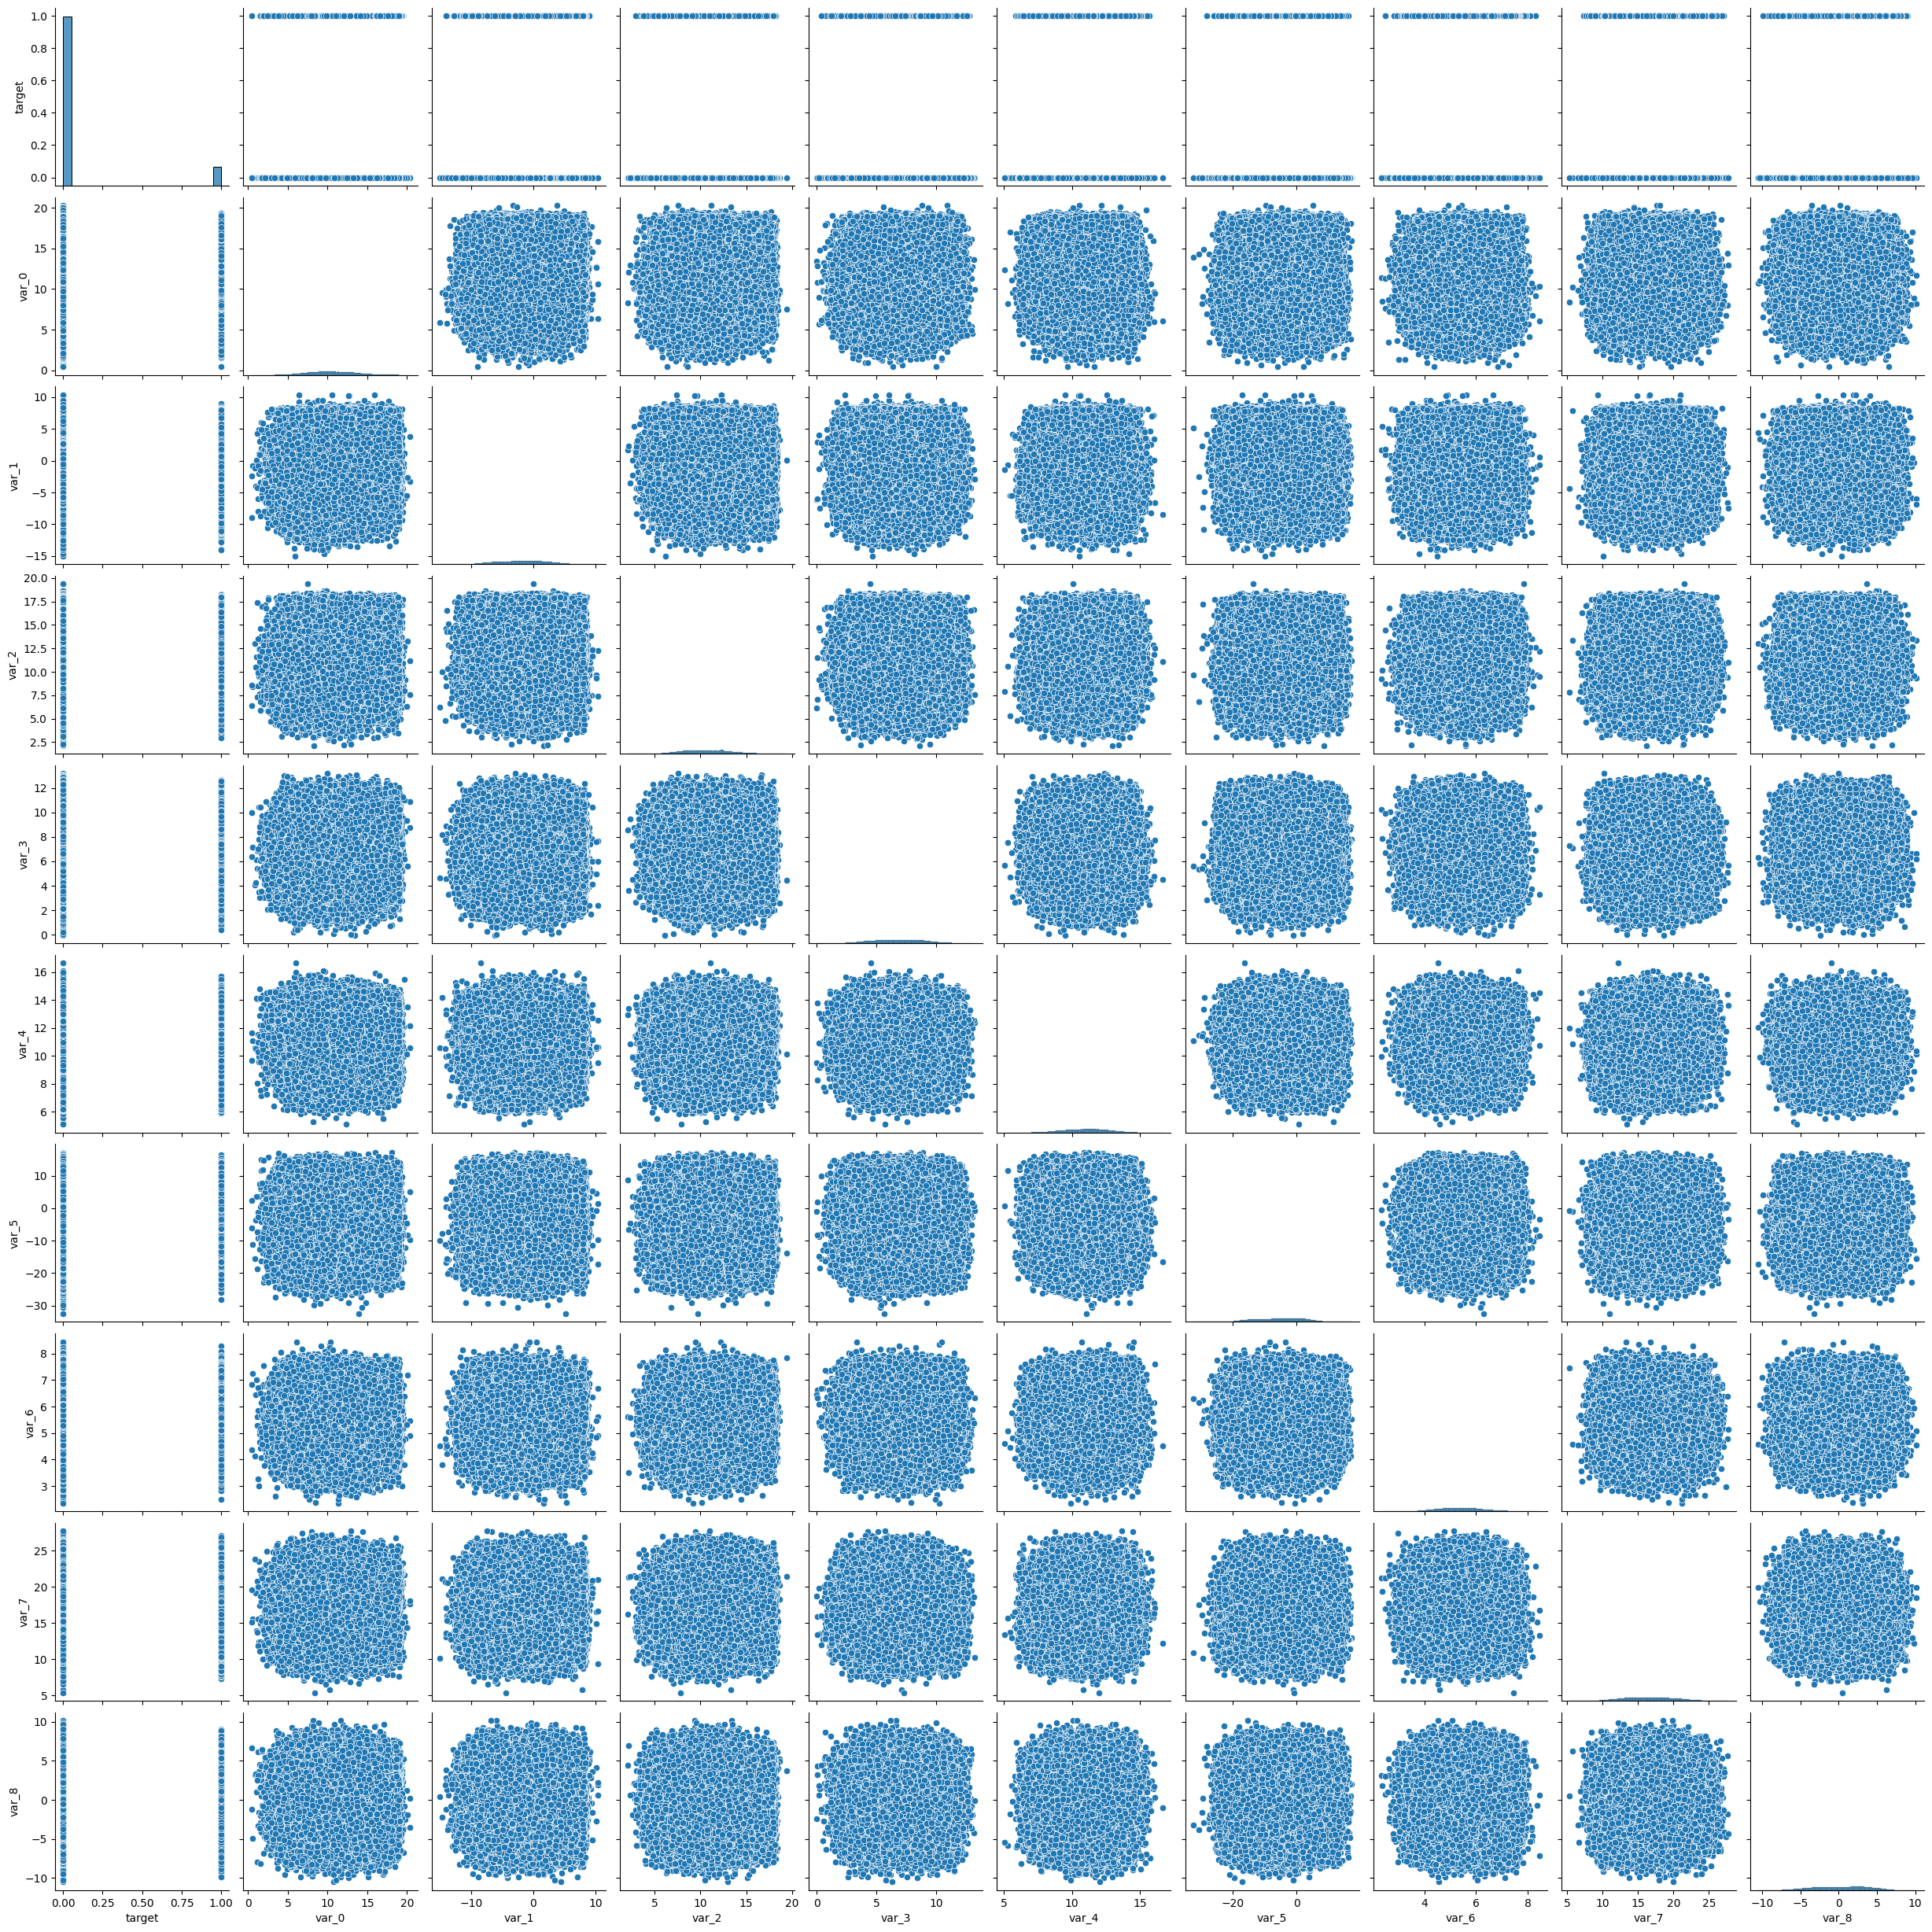

In [ ]:
sns.pairplot(df_train.iloc[:,0:10])

We have so many features and to reduce them one approache is we can keep high correlate features with target variable.

**Note**: Another thing we see that train and test set are same and we do not need test set for further analysis probably, for memory usage we remove it from environment.

In [ ]:
import gc

del df_test
gc.collect()

0

For example we use pearson correlation for this approache

In [ ]:
pear_corr = df_train.corrwith(df_train['target'], numeric_only=True).abs().sort_values(ascending=False)

lets create interval for these correlations

In [ ]:
bin_corr = pd.cut(x=pear_corr, bins=[0, 0.1, 0.4, 1], include_lowest=0)

Lets visualize the histograms of bins.

In [ ]:
bin_corr

target     (0.4, 1.0]
var_81     (0.0, 0.1]
var_139    (0.0, 0.1]
var_12     (0.0, 0.1]
var_6      (0.0, 0.1]
              ...    
var_38     (0.0, 0.1]
var_17     (0.0, 0.1]
var_30     (0.0, 0.1]
var_27     (0.0, 0.1]
var_185    (0.0, 0.1]
Length: 201, dtype: category
Categories (3, interval[float64, right]): [(0.0, 0.1] < (0.1, 0.4] < (0.4, 1.0]]

In [ ]:
bin_corr.value_counts()

(0.0, 0.1]    200
(0.4, 1.0]      1
(0.1, 0.4]      0
dtype: int64

So as we saw all variables except target variable have absolute value of pearson correlation value between `0 and 0.1`

So we can not decide to remove some features to reduce the dimension and we need all features probably to achieve good result.

**Note**: you can use other correlation metrics and approach to reduce dimension. maybe we use it if we can not get good result in performance and efficiency of our computation.

---

So by now we done our Exploratory data analysis.


---
***Now we should show our ability as an data scientis in predictive analysis area.***

# Data preprocessing for predictive analysis

we can do several things for imbalanced dataset:
- Class weight approache
- Downsampling
- Upsampling
- Resampling

Import necessary library for imbalance dataset.

In [5]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, KMeansSMOTE, SMOTE, SMOTEN

Our data set is clean but first we want to analyse it without Dimension reduction technique like `PCA` or `Clustering` ...
but you have to know your data set so good, because when you do Dimension Reduction technique you lose some information



---



import necessary libraries

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df_train.iloc[:, 1:]
y = df_train.target

X.shape, y.shape

((200000, 200), (200000,))

**Note:** in kaggle competitions ussually we have 2 dataset one for train and another one for test so we can train our model on entire train dataset after validate our model.
and another thing is that you have to check that do you have same values and features in train and test set or there are some differences.

Let's our data set into `train` and `validate`.

`Tip`: If you get enough accuracy in ypu model, you can improve it by `Psudo labeling technique` but be aware about **overfitting**.

we use `stratify` parametere here because we want to save ferquency of target in train and validate sets

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

As we can see validate and train sets have same relative ferquencies for their values but they are very `imbalance`.

In [9]:
y_train.value_counts(normalize=1), y_valid.value_counts(normalize=1)

(0    0.899507
 1    0.100493
 Name: target, dtype: float64,
 0    0.899517
 1    0.100483
 Name: target, dtype: float64)

## data sampling for imbalance dataset

Because we have a big dataset and we do not want to create instances that are not 100 pecent real so we decide to do downsampling first.

### Downsampling

#### RandomUnderSampler, NearMiss

Define a function for these works.

In [10]:
def resample(X_train, y_train):
  # Nearmiss
  nm = NearMiss()
  # RandomUnderSampler
  under_sampler = RandomUnderSampler(random_state=123)
  # Resampled datasets
  X_near, y_near = nm.fit_resample(X_train, y_train)
  X_under, y_under = under_sampler.fit_resample(X_train, y_train)

  return X_near, y_near, X_under, y_under

In [11]:
X_near, y_near, X_under, y_under = resample(X_train, y_train)

In [12]:
y_near.value_counts(normalize=1), y_under.value_counts(normalize=1)

(0    0.5
 1    0.5
 Name: target, dtype: float64,
 0    0.5
 1    0.5
 Name: target, dtype: float64)

As you can see we implement undersampling teqnique for our train dataset using `NearMiss` and `RandomUnderSampler`.

---



---


**Note**: you can use cuML and imblearn together to compute resampling faster.
Reference: [Medium](https://medium.com/rapids-ai/faster-resampling-with-imbalanced-learn-and-cuml-6cfc1dae63bf)

As you can see our transformers remove some instances from target variable to create new target variable with balance ferquency.

In [ ]:
y_near.shape, y_train.shape

((28138,), (140000,))

#### Train basic model for downsample and original dataset

So lets train a basic model like Logistic regression on original dataset and transfered dataset.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

Implement on transfered and original dataset

In [ ]:
lg_t = LogisticRegression(solver='liblinear')

lg_o = LogisticRegression(solver='liblinear')

lg_t.fit(X_near, y_near)
lg_o.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Evaluate metrics on validation set for our models.
**Note**: do not forget to use metrics that can show use better evaluation for inbalance datset. like `roc_auc_score`, `recall_score`, `f1score`, `precision_recall_curve`

In [ ]:
y_valid.value_counts(normalize=1), y_valid.shape

(0    0.899517
 1    0.100483
 Name: target, dtype: float64,
 (60000,))

In [ ]:
pred = lg_t.predict(X_valid)
print(classification_report(y_true=y_valid, y_pred=pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     53971
           1       0.29      0.76      0.42      6029

    accuracy                           0.79     60000
   macro avg       0.63      0.77      0.64     60000
weighted avg       0.90      0.79      0.83     60000



In [ ]:
roc_auc_score(y_true=y_valid, y_score=pred)

0.7740999856114714

In [ ]:
lg_t.predict_proba(X_valid)[:, 0]

array([0.87465015, 0.96278284, 0.6570148 , ..., 0.87312233, 0.92906116,
       0.97492146])

In [ ]:
roc_auc_score(y_true=y_valid, y_score=lg_t.predict_proba(X_valid)[:, 1])

0.8539277921807333

In [ ]:
pred = lg_o.predict(X_valid)
print(classification_report(y_true=y_valid, y_pred=pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     53971
           1       0.68      0.27      0.39      6029

    accuracy                           0.91     60000
   macro avg       0.80      0.63      0.67     60000
weighted avg       0.90      0.91      0.90     60000



In [ ]:
roc_auc_score(y_true=y_valid, y_score=pred)

0.6273658513874989

So we found the problem of previous commited noteboke and solve it, because it was shouing us false info about 100% accuracy.
**Note**: always check further analysis to be confidet about your accuracy.

So as you can see `recall` and `roc_auc_score` became better than before and vice versa for `precision` for minority class but it still need more investigate.

### Create model with downsample dataset

**Note**: one important thing is when we see problem like this we should decide `what threshold` do you want to choose and `what class of target` do you care more about. So for this thing we always should look at `ROC_AUC Curve`.


---
For previous models threshold was 0.50 to classfied positive label.

Import Libs

In [13]:
from sklearn import metrics as mtc
import cuml
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

Scale the dataset

In [14]:
scaler = StandardScaler()
X_near = scaler.fit_transform(X_near)
X_valid = scaler.transform(X_valid)

Lets create a function for evaluate.

---


Important thing is we want to find a classifier model that can achieved balance between pos and neg labels prediction.

In [15]:
results = []
def evaluate(yt, yp, model_type):
    results_pos = {}
    results_pos['type'] = model_type
    # Accuracy
    results_pos['accuracy'] = mtc.accuracy_score(yt, yp)
    # Precision, recall, Fscore
    # Note that we use beta=5 which means we think the cost of positive class is 1 times of negative class
    precision, recall, f_beta, _ = mtc.precision_recall_fscore_support(yt, yp, beta=1, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC for 0.5 threshold
    results_pos['auc'] = mtc.roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos


#### SVM

**Tip**: We can use kernel approximation if it take to long to compute.

In [16]:
params = {'C':[0.2*x for x in range(1,20, 2)],
          'kernel':['rbf', 'sigmoid'], 'gamma':['auto']}

svc = cuml.svm.SVC()
gr_svc = GridSearchCV(estimator=svc, param_grid=params, cv=3, scoring='roc_auc')
gr_svc.fit(X_near, y_near)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.2, 0.6000000000000001, 1.0, 1.4000000000000001,
                               1.8, 2.2, 2.6, 3.0, 3.4000000000000004,
                               3.8000000000000003],
                         'gamma': ['auto'], 'kernel': ['rbf', 'sigmoid']},
             scoring='roc_auc')

In [17]:
gr_svc.best_params_

{'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}

In [18]:
# it is like predict_proba method when you want to use roc_auc_score
# In binary classification above 0 predict as class 1 and below that predict as class 0 for threshold 0.5 in model.predict() method
# if we want to enable predict for svc model it takes to long to finished it
gr_svc.decision_function(X_valid)[0:10]

array([ 0.33984119, -0.74671099,  1.4442753 ,  0.53903483,  3.47645109,
       -0.29606915, -0.84742284,  0.36312099, -1.2420825 , -1.46109105])

In [20]:
pred = gr_svc.predict(X_valid)
results.append(evaluate(model_type='SVC', yp=pred, yt=y_valid))

In [21]:
pred[0:10]

array([1, 0, 1, 1, 1, 0, 0, 1, 0, 0])

In [22]:
results

[{'type': 'SVC',
  'accuracy': 0.6039,
  'recall': 0.8770940454470061,
  'auc': 0.7252380234461133,
  'precision': 0.18676932857697878,
  'fscore': 0.30796109719876535}]

#### Linear SVC
Lets Implement Linear SVC because we have so many features

In [23]:
params = {'C':[x for x in range(1,20, 2)], 'penalty':['l1', 'l2']}
linearsvc = cuml.svm.LinearSVC(probability=True)
gr_lsvc = GridSearchCV(estimator=linearsvc, param_grid=params, cv=3, scoring='roc_auc')
gr_lsvc.fit(X_near, y_near)

GridSearchCV(cv=3, estimator=LinearSVC(),
             param_grid={'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [24]:
gr_lsvc.best_params_

{'C': 1, 'penalty': 'l2'}

In [25]:
pred = gr_lsvc.predict(X_valid)
print(mtc.classification_report(y_true=y_valid, y_pred=pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     53971
           1       0.29      0.75      0.42      6029

    accuracy                           0.79     60000
   macro avg       0.63      0.77      0.64     60000
weighted avg       0.90      0.79      0.83     60000



In [26]:
pred = gr_lsvc.predict(X_valid)
results.append(evaluate(model_type='LinearSVC', yp=pred, yt=y_valid))

We active probability for this model(linearsvc) now lets look at roc_auc curve with various threshold. (pos label is 1 by default)

In [38]:
gr_lsvc.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [40]:
gr_lsvc.cv_results_['mean_test_score']

array([0.84223035, 0.84223419, 0.84222919, 0.84223411, 0.84222938,
       0.84223413, 0.84222975, 0.84223407, 0.84222957, 0.84223411,
       0.84222999, 0.84223411, 0.84223001, 0.8422341 , 0.84222964,
       0.84223411, 0.84222967, 0.84223408, 0.84222964, 0.84223408])

In [27]:
mtc.roc_auc_score(y_true=y_valid, y_score=gr_lsvc.predict_proba(X_valid)[:,1])

0.8544343886122608

As you can see we plot several curves and we can see plot curve with decision function and probability of grater label (1) is equal.
Another thing is if we plus AUC of red plot and AUC of green plot it will be equal to 1.

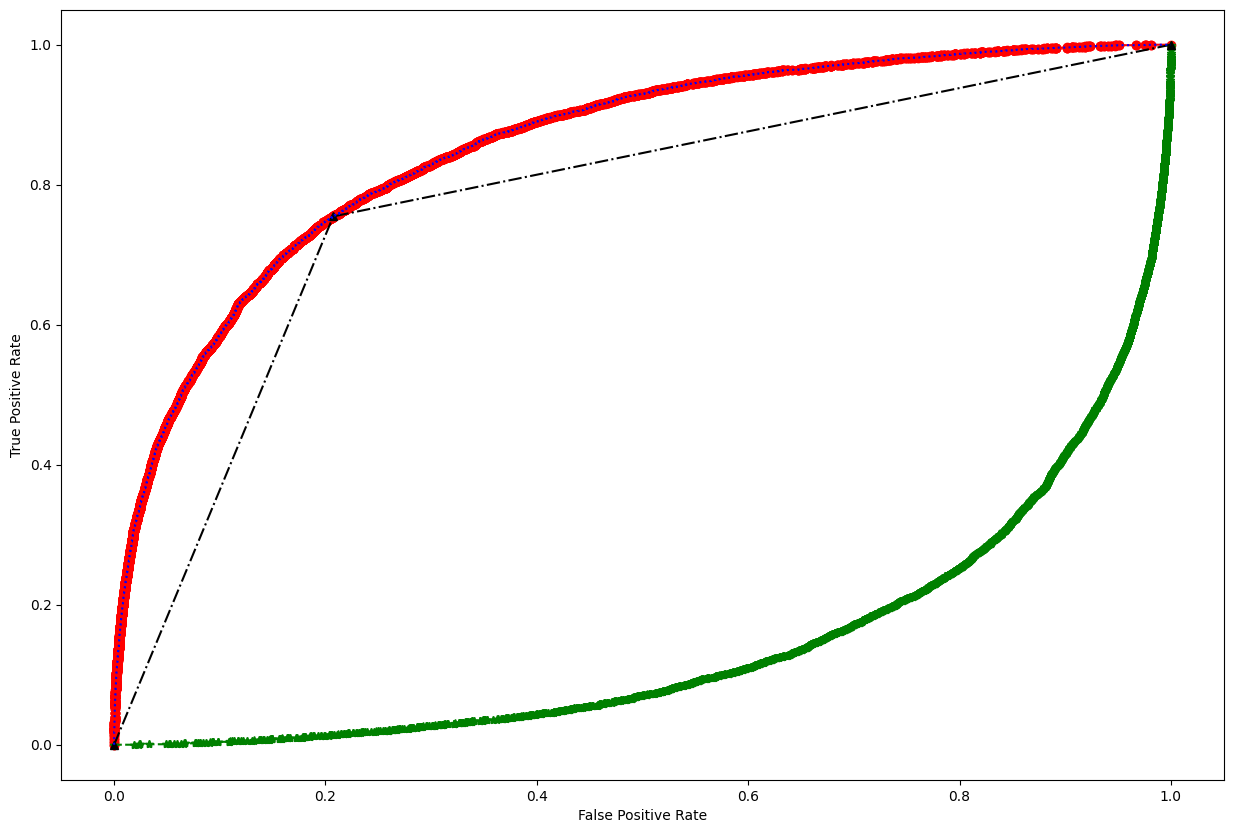

In [28]:
#define metrics
#probability
y_pred_proba = gr_lsvc.predict_proba(X_valid)
# predict with 0.5 threshold
pred = gr_lsvc.predict(X_valid)
# decision function
# Return Confidence scores per (n_samples, n_classes) combination. In the binary case,
# confidence score for self.classes_[1] where >0 means this class would be predicted.
decision = gr_lsvc.decision_function(X_valid)

# roc curve for when positive labe is 1 and we pass the probability of class 1
fpr_1, tpr_1, thresholds = mtc.roc_curve(y_valid,  y_pred_proba[:,1])
# roc curve for when positive labe is 1 and we pass the probability of class 0
fpr_0, tpr_0, thresholds = mtc.roc_curve(y_valid,  y_pred_proba[:,0])
# roc curve for when we do not pass probability and we pass predicted label with 0.5 threshold (function pick 3 threshold for it)
fpr_p, tpr_p, thresholds = mtc.roc_curve(y_valid,  pred)
# roc curve for with decision function
fpr_d, tpr_d, thresholds = mtc.roc_curve(y_valid,  decision)



#create ROC curve
plt.figure(figsize=(15,10))
plt.plot(fpr_1,tpr_1, marker='o', ls='-', color='red')
plt.plot(fpr_0,tpr_0, marker='*', ls='--', color='green')
plt.plot(fpr_p,tpr_p, marker='^', ls='-.', color='black')
plt.plot(fpr_d,tpr_d, marker='', ls=':', color='blue')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

For more information: [ROC Curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html), [ROC_AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), [Decision function of linearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function)

#### Logistic Regression

In [29]:
params = {'C':[0.2*x for x in range(1,20, 2)],
          'penalty':['l1','l2']}

lgr = cuml.linear_model.LogisticRegression(max_iter=10000)
gr_lg = GridSearchCV(estimator=lgr, param_grid=params, cv=3, scoring='roc_auc')
gr_lg.fit(X_near, y_near)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.2, 0.6000000000000001, 1.0, 1.4000000000000001,
                               1.8, 2.2, 2.6, 3.0, 3.4000000000000004,
                               3.8000000000000003],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [30]:
gr_lg.best_params_, gr_lg.best_score_

({'C': 0.2, 'penalty': 'l1'}, 0.8421774947756328)

In [41]:
pred = gr_lg.predict(X_valid)
results.append(evaluate(model_type='Logistic', yp=pred, yt=y_valid))

In [42]:
mtc.roc_auc_score(y_true=y_valid, y_score=gr_lg.predict_proba(X_valid)[:,1])

0.8543480986218192

#### RandomForest

In [43]:
params = {'n_estimators':[100,200,300,400],'split_criterion':[0,1],
          'max_depth':[16,20], 'max_features':['sqrt']}

rf = cuml.ensemble.RandomForestClassifier(bootstrap=True)
gr_rf = GridSearchCV(estimator=rf, param_grid=params, cv=3, scoring='roc_auc')
gr_rf.fit(X_near.astype('float32'), y_near)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [16, 20], 'max_features': ['sqrt'],
                         'n_estimators': [100, 200, 300, 400],
                         'split_criterion': [0, 1]},
             scoring='roc_auc')

In [44]:
gr_rf.best_params_, gr_rf.best_score_

({'max_depth': 20,
  'max_features': 'sqrt',
  'n_estimators': 400,
  'split_criterion': 1},
 0.8956830027527966)

In [45]:
pred = gr_rf.predict(X_valid)
results.append(evaluate(model_type='RandoForest', yp=pred, yt=y_valid))

In [46]:
mtc.roc_auc_score(y_true=y_valid, y_score=gr_rf.predict_proba(X_valid)[:,1])

0.8080093903227408

#### Gradient Boosting
Gradient boost is more robust that ada boost

In [47]:
import lightgbm as lgb

In [48]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : 123,
    "verbosity" : 1,
    "seed": 123
}

In [50]:
gb = lgb.LGBMClassifier(**lgb_params)

In [51]:
gb.fit(X_near, y_near)

[LightGBM] [Warning] Unknown parameter: min_sum_heassian_in_leaf
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.05, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] Unknown parameter: min_sum_heassian_in_leaf
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.05, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05
[LightGBM] [Warning] boosting is set=gbdt, boo

LGBMClassifier(bagging_fraction=0.4, bagging_freq=5, bagging_seed=123,
               boost_from_average='false', boosting='gbdt',
               feature_fraction=0.05, learning_rate=0.01, metric='auc',
               min_data_in_leaf=80, min_sum_heassian_in_leaf=10, num_leaves=13,
               objective='binary', seed=123, tree_learner='serial',
               verbosity=1)

In [52]:
pred = gb.predict(X_valid)
results.append(evaluate(model_type='GradientBoost', yp=pred, yt=y_valid))

In [57]:
mtc.roc_auc_score(y_true=y_valid, y_score=gb.predict_proba(X_valid)[:, 1])

0.7957038500852447

#### Visualize the results

In [83]:
pd.DataFrame(results)

type  accuracy    recall       auc  precision    fscore
0            SVC  0.603900  0.877094  0.725238   0.186769  0.307961
1      LinearSVC  0.788867  0.754686  0.773685   0.289091  0.418045
2       Logistic  0.788317  0.755017  0.773527   0.288540  0.417519
3    RandoForest  0.675800  0.786863  0.725128   0.207062  0.327851
4  GradientBoost  0.613667  0.819373  0.705030   0.182753  0.298851

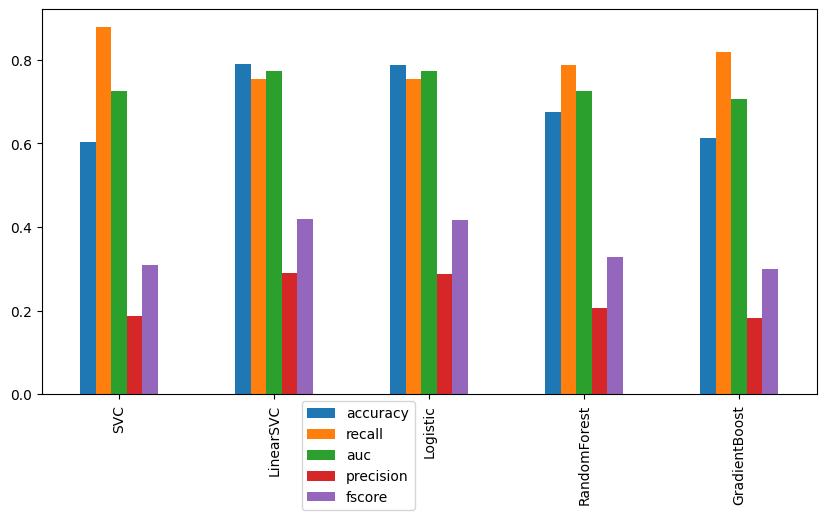

In [82]:
ax = pd.DataFrame(results).plot(kind='bar', figsize=(10,5))
ax.set_xticklabels(['SVC', 'LinearSVC', 'Logistic', 'RandomForest', 'GradientBoost'])
plt.legend(loc='best', bbox_to_anchor=(0.49, 0, 0, 0))
plt.show()

#### Evaluate AUC score for our models

In [89]:
# scale the X_train
X_train = scaler.transform(X_train)

In [92]:
auc_results = []
labels = ['SVC', 'LinearSVC', 'Logistic', 'RandomForest', 'GradientBoost']
models = [gr_svc, gr_lsvc, gr_lg, gr_rf, gb]
for l,m in zip(labels,models):
  if l == 'SVC':
      score_val = mtc.roc_auc_score(y_true=y_valid, y_score=m.predict(X_valid))
      score_tra = mtc.roc_auc_score(y_true=y_train, y_score=m.predict(X_train))
      score_res = mtc.roc_auc_score(y_true=y_near, y_score=m.predict(X_near))
      auc_results.append({'Models':l, 'valid':score_val, 'train':score_tra, 'resampleSet':score_res})
      continue
  score_val = mtc.roc_auc_score(y_true=y_valid, y_score=m.predict_proba(X_valid)[:, 1])
  score_tra = mtc.roc_auc_score(y_true=y_train, y_score=m.predict_proba(X_train)[:, 1])
  score_res = mtc.roc_auc_score(y_true=y_near, y_score=m.predict_proba(X_near)[:, 1])
  auc_results.append({'Models':l, 'valid':score_val, 'train':score_tra, 'resampleSet':score_res})



In [99]:
pd.DataFrame(auc_results)

Models     valid     train  resampleSet
0            SVC  0.725238  0.766659     0.964461
1      LinearSVC  0.854434  0.859892     0.848737
2       Logistic  0.854348  0.859882     0.848764
3   RandomForest  0.808009  0.961397     0.999853
4  GradientBoost  0.795704  0.808500     0.935181

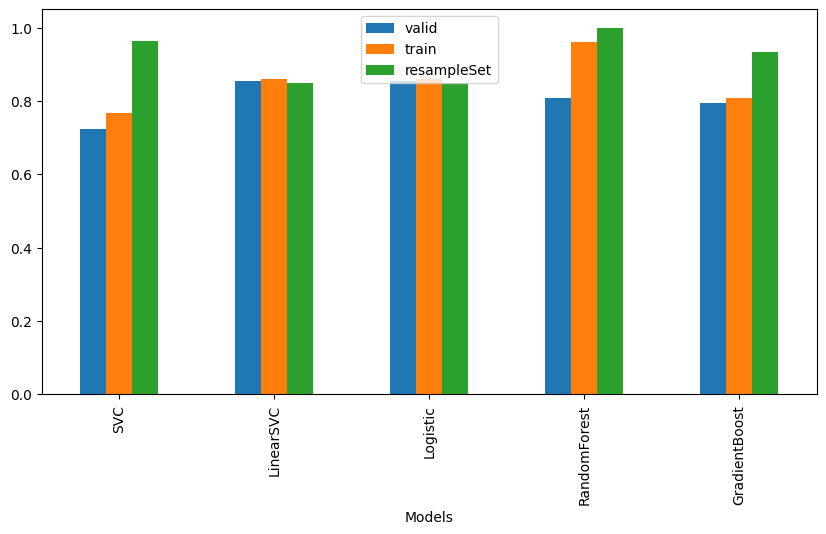

In [98]:
pd.DataFrame(auc_results).set_index('Models').plot(kind='bar', figsize=(10,5))
plt.legend(loc='upper center')
plt.show()

# In coclusion
We can see our model perform good when we use downsampling technique but when we do that precision will decrease but as we said we want to look what we want form our analysis, in this analysis we want to create models that can predict the target values in balance and not good at one value but not the other one, high `True Positive Rate` and less `False Positive Rate`.

as we can see previous plots `LinearSVC` and `Logistic` can perform well on our problem.

---

Keep in mind our job as a data scientis is not only create a model but also we have to improve it with another techniques and also maybe use another complex models to increase the accuracy of our model on problem.